In [28]:
import pandas as pd
import numpy as np
import datetime as datetime
import math
#from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
#from tqdm import tqdm
import random
from scipy.stats import ttest_ind
#tqdm.pandas()

#POUR ELOISE
from math import cos, sqrt, pi, atan2, sin

In [70]:
data_folder = './data/'

#name of the different datasets we are going to use during this creative extension
name_b_checkins = data_folder +'loc-brightkite_totalCheckins.txt.gz'
name_b_edges = data_folder +'loc-brightkite_edges.txt.gz'

name_g_checkins = data_folder +'loc-gowalla_totalCheckins.txt.gz'
name_g_edges = data_folder +'loc-gowalla_edges.txt.gz'

name_countries = data_folder +'countries.csv'
name_events = data_folder + 'events.csv'

# extraction of the datasets
brightkite_checkins = pd.read_csv(name_b_checkins, compression='gzip', sep='\t',header = None)
b_edges = pd.read_csv(name_b_edges, compression='gzip', sep='\t',header = None)

gowalla_checkins = pd.read_csv(name_g_checkins, compression='gzip', sep='\t',header = None)
g_edges = pd.read_csv(name_g_edges, compression='gzip', sep='\t',header = None)

countries = pd.read_csv(name_countries, sep = ';')
events = pd.read_csv(name_events, sep = ';')

In [3]:
#Renaming the columns in the given dataframes with the names given.
b_checkins = brightkite_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})
g_checkins = gowalla_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})
b_edges = b_edges.rename(columns = {0: 'user', 1:'friend'})
g_edges = g_edges.rename(columns = {0: 'user', 1:'friend'})

#Checking the number of checkins we have in each dataframe.
print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))

Number of checkins in Brightkite: 4747287
Number of checkins in Gowalla: 6442892


In [4]:
b_checkins.head()

,user,checkin_time,latitude,longitude,location_id
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc


In [5]:
g_checkins.head()

,user,checkin_time,latitude,longitude,location_id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [6]:
# Checking for rows with impossible longitudes/latitudes and removing them if needed.

b_checkins.drop(b_checkins[(b_checkins.latitude>90.0)|(b_checkins.latitude<-90.0)].index, inplace = True)
b_checkins.drop(b_checkins[(b_checkins.longitude>180.0)|(b_checkins.longitude<-180.0)].index, inplace = True)
b_checkins.drop(b_checkins[b_checkins['latitude'].isnull()].index, inplace=True)
b_checkins.drop(b_checkins[b_checkins['longitude'].isnull()].index, inplace=True)


#I noticed thousands of checkins at the location (0.0, 0.0) that corresponds to a spot in the Atlantic Ocean. I assumed it
#was an error in the system and simply chose to drop them
b_checkins = b_checkins[(b_checkins.longitude !=0)|(b_checkins.latitude!=0)]

#We drop in checkin_g the rows that contain null values in longitude and latitude, and latitudes above and below 90 and -90
#and longitudes above and below 180 and -180

g_checkins.drop(g_checkins[(g_checkins.latitude>90.0)|(g_checkins.latitude<-90.0)].index, inplace = True)
g_checkins.drop(g_checkins[(g_checkins.longitude>180.0)|(g_checkins.longitude<-180.0)].index, inplace = True)
g_checkins.drop(g_checkins[g_checkins['latitude'].isnull()].index, inplace=True)
g_checkins.drop(g_checkins[g_checkins['longitude'].isnull()].index, inplace=True)

#As for Brightkite there were thousands of checkins at the location (0.0, 0.0) that corresponds to a spot in the Atlantic 
#Ocean. I assumed it was also an error in the system and dropped
g_checkins = g_checkins[(g_checkins.longitude !=0)|(g_checkins.latitude!=0)]

print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))

Number of checkins in Brightkite: 4491035
Number of checkins in Gowalla: 6442728


In [9]:
world_map = plt.imread('./Data/world_map4.png')

def plot_on_map(df, name_ds) :
    """ Plot on a map of the world all the checkins
    
    Parameters
    ----------
    df : Dataframe
        Contains all the checkins, expressed in terms of latitude and of longitude, to plot on the world map
    """
    fig, ax = plt.subplots(figsize = (15,10))
    BBox = (df.longitude.min(),df.longitude.max(),df.latitude.min(), df.latitude.max())
    ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 0.2, c='b', s=10)
    ax.set_title('Plotting Spatial Data of the '+name_ds+ ' dataset')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(world_map, zorder=0, extent = BBox, aspect= 'equal')

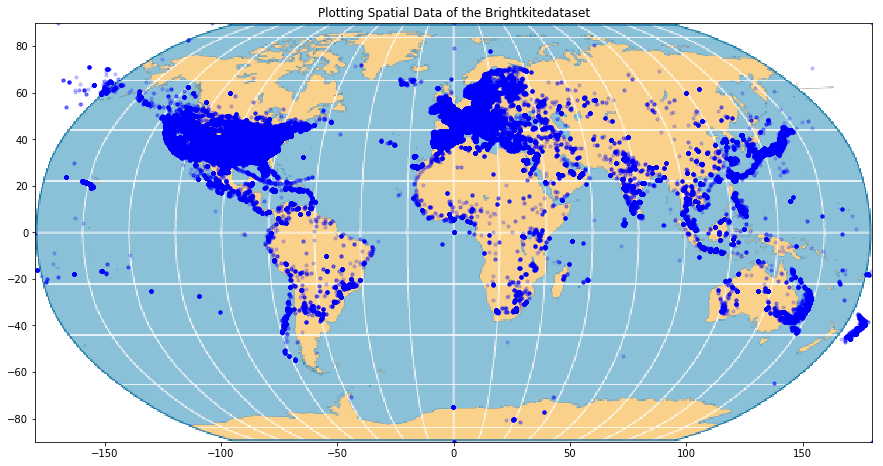

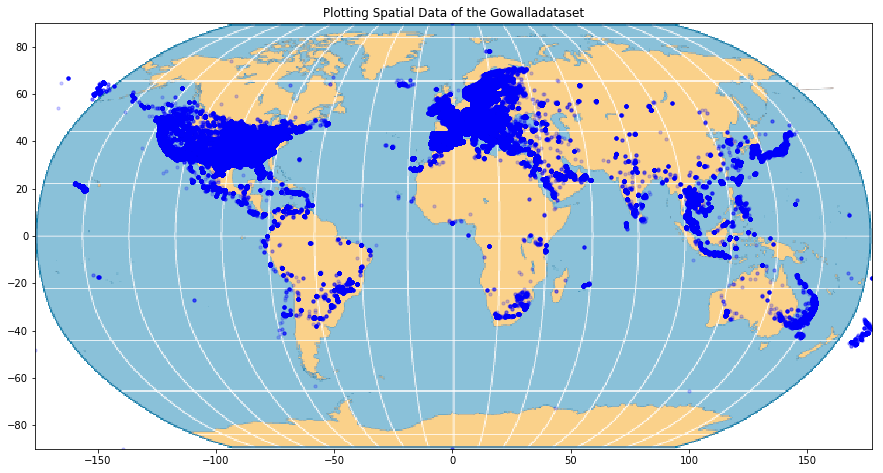

In [10]:
plot_on_map(b_checkins, 'Brightkite')
plot_on_map(g_checkins, 'Gowalla')

## Placing the checkins in the continents

In [12]:
countries.set_index('area', inplace = True)
countries.head()

,bottom_left_lat,bottom_left_long,top_right_lat,top_right_long
area,,,,
usa,24.539159,-125.325272,49.000000,-60.128423
western_europe,35.904000,-10.000000,59.128197,8.212485
east_asia,29.895673,125.792187,45.652509,145.745126


<span style="background-color:yellow">TODO : Add the screenshots of the countries we have selected</span>

In [13]:
def is_in_country(row, country):
    country_lat_range = range(int(country['bottom_left_lat']), int(country['top_right_lat'])+1)
    country_long_range = range(int(country['bottom_left_long']), int(country['top_right_long'])+1)
    return (int(row['latitude']) in country_lat_range) & (int(row['longitude']) in country_long_range)

In [30]:
b_checkins['is_in_usa'] = b_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)
g_checkins['is_in_usa'] = g_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)

b_checkins['is_in_europe'] = b_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)
g_checkins['is_in_europe'] = g_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)

b_checkins['is_in_asia'] = b_checkins.progress_apply(lambda row: is_in_country(row, countries.loc['east_asia']), axis=1)
g_checkins['is_in_asia'] = g_checkins.progress_apply(lambda row: is_in_country(row,countries.loc['east_asia']), axis=1)

100%|██████████| 6442727/6442727 [24:11<00:00, 4437.52it/s]  


In [14]:
## POUR ELOISE

b_checkins['is_in_usa'] = b_checkins.apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)
g_checkins['is_in_usa'] = g_checkins.apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)

b_checkins['is_in_europe'] = b_checkins.apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)
g_checkins['is_in_europe'] = g_checkins.apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)

b_checkins['is_in_asia'] = b_checkins.apply(lambda row: is_in_country(row, countries.loc['east_asia']), axis=1)
g_checkins['is_in_asia'] = g_checkins.apply(lambda row: is_in_country(row,countries.loc['east_asia']), axis=1)

In [15]:
b_checkins.head()

,user,checkin_time,latitude,longitude,location_id,is_in_usa,is_in_europe,is_in_asia
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,True,False,False
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,True,False,False
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,True,False,False
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,True,False,False
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,True,False,False


In [16]:
g_checkins.head()

,user,checkin_time,latitude,longitude,location_id,is_in_usa,is_in_europe,is_in_asia
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,True,False,False
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315,True,False,False
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,True,False,False
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,True,False,False
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,True,False,False


In [17]:
print('There is ' + str(len(b_checkins[b_checkins['is_in_usa']]))+ ' checkins in USA in the Brightkite dataset')
print('There is ' + str(len(g_checkins[g_checkins['is_in_usa']]))+ ' checkins in USA in the Gowalla dataset')
print('\n')
print('There is ' + str(len(b_checkins[b_checkins['is_in_europe']]))+ ' checkins in Western Europe in the Brightkite dataset')
print('There is ' + str(len(g_checkins[g_checkins['is_in_europe']]))+ ' checkins in Western Europe in the Gowalla dataset')
print('\n')
print('There is ' + str(len(b_checkins[b_checkins['is_in_usa']]))+ ' checkins in East Asia in the Brightkite dataset')
print('There is ' + str(len(g_checkins[g_checkins['is_in_usa']]))+ ' checkins in East Asia in the Gowalla dataset')


There is 2923138 checkins in USA in the Brightkite dataset
There is 3675793 checkins in USA in the Gowalla dataset


There is 463770 checkins in Western Europe in the Brightkite dataset
There is 776569 checkins in Western Europe in the Gowalla dataset


There is 2923138 checkins in East Asia in the Brightkite dataset
There is 3675793 checkins in East Asia in the Gowalla dataset


We are only going to study the checkins that happened or in the USA or in Western Europe or in Japan :

In [19]:
b_checkins = b_checkins[b_checkins['is_in_europe'] | b_checkins['is_in_usa'] | b_checkins['is_in_asia']]
g_checkins = g_checkins[g_checkins['is_in_europe'] | g_checkins['is_in_usa'] | g_checkins['is_in_asia']]

In [20]:
print('That is '+ str(len(b_checkins))+ ' for the Brightkite dataset and '+ str(len(g_checkins))+ ' for the Gowalla one')

That is 3809852 for the Brightkite dataset and 4519096 for the Gowalla one


#### Interprétation:

je pense que faire ensuite un texte sur le fait que va y avoir des checkins qui vont correspondre à deux pays mais que c’est pas trop grave parce que ça veut dire que c’est des zones limitrophes et donc que elles ont potentiellement des influences culturelles des deux pays, particulierement en europe c’est pas mal nan?

In [21]:
b_checkins.to_csv(r'./data/b_checkins_with_countries.txt.gz', compression='gzip', index = False)
g_checkins.to_csv(r'./data/g_checkins_with_countries.txt.gz', compression='gzip', index = False)

In [86]:
b_checkins = pd.read_csv('Data/b_checkins_with_countries.txt.gz', compression = 'gzip')
g_checkins = pd.read_csv('Data/g_checkins_with_countries.txt.gz', compression = 'gzip')

# Finding the homes of the users and classifying them in each continent

## Making the conversions

We create the different functions and constants needed for assigning the locations to cells.
The function get_cell_coordinates gives the wanted coordinates of the cell given the latitude and longitude.

In [87]:
#lat_deg_in_km is the coefficient of conversion of a latitude in degrees to latitude in kilometers
#side_of_square is the size of the side of the cells in the discretized world in kilometers
#long_deg_in_km is the constant coefficient of conversion of a longitude in degrees to kilometers

lat_deg_in_km = 110.574
side_of_square = 25
long_deg_in_km = 111.3290

In [88]:
#the function long_deg_to_km returns the total coefficent of conversion of a longitude in degrees to kilometers in function 
#of the latitude and long_deg_in_km
def long_deg_to_km(lat):
    return long_deg_in_km*np.cos(lat)


#get_cell_coordinates obtains the coordinates in the discretized world (squares of 25 by 25 km) from a location in
#latitude and longitude, we simply multiply the latitude by lat_deg_in_km and divide it by side_of_square
#and multiply the longitude by long_deg_to_km(lat) and divide it by side_of_square
def get_cell_coordinates(lat, long):
    x_coord = int((long*long_deg_to_km(lat))/side_of_square)
    y_coord = int((lat*lat_deg_in_km)/side_of_square)
    return (x_coord, y_coord)

## Assigning cells

Now we can assign to the locations the corresponding coordinates in the discrertized world. We simply add a new column in each checkin dataframe and apply to it the previously made get_cell_coordinates function.

In [89]:
#we add a new column to the dataframe checkin_b. This column(named cell_coord) contains the coordinates of the checkins
#in the discretized world. We obtain it by simply applying the function get_cell_coordinates to each row
b_checkins['cell_coord'] = b_checkins.progress_apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)
g_checkins['cell_coord'] = g_checkins.progress_apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)


AttributeError: 'DataFrame' object has no attribute 'progress_apply'

In [90]:
# POUR ELOISE
b_checkins['cell_coord'] = b_checkins.apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)
g_checkins['cell_coord'] = g_checkins.apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)


## 3. Finding the homes of the users

We now want to find the home of each user. It is assumed that it is the cell that has the most checkins of this user. If there are several cells with the maximum number of checkins, I just kept the one that appeared first in the Dataframe. If there are two cells that have the maximum number of checkins, this is probably because one is the home and the other the worlplace.

In [47]:
#This function finds the homes of the users given a dataframe containing all the checkins(with columns : user,
#cell_coords, latitudes and longitudes)

def finding_homes(df):
    
    #We insert a column count (that for the moment countains only ones) in the dataframe that will contain how many 
    #checkins were made by a user in a cell_coord
    df.insert(0, "count", [1]*df.shape[0], True)
    
    #To count the number of checkins, we do a groupby on user and cell_coord. We count the number of checkins in each
    #groupby, and to obtain the latitude and longitude of checkins in this cell, we do a mean of all latitudes and
    #longitudes that are in this cell. We drop the rows with NaNs in them and reset the index for convenience
    df = df.groupby(['user', 'cell_coord']).agg({'count' : 'count', 'latitude' : 'mean', 'longitude':'mean'})
    df.dropna(axis=0, inplace=True)
    df.reset_index(inplace = True)
    
    #We sort the values by descending order in count, so that the cells with the most count are at the top for each user
    df.sort_values(by = 'count', ascending=False, inplace = True)
    
    #We drop the duplicates of user to keep only the cell with the biggest count as it is at the top. For convenience
    #we set user as the index sorted by ascending order
    df.drop_duplicates(subset = 'user', keep= 'first', inplace=True)
    df.sort_values(by='user', inplace=True)
    df.set_index('user', inplace = True)
    return df

In [48]:
#We call the function finding_homes on the checkins in Brightkite

homes_in_b = b_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_b = finding_homes(homes_in_b)
homes_in_b.reset_index(inplace = True)
homes_in_b.head()

,user,cell_coord,count,latitude,longitude
0,0,"(272, 176)",229,39.891261,-105.068678
1,1,"(-543, 166)",357,37.628486,-122.419079
2,2,"(211, 175)",305,39.739295,-104.982155
3,3,"(-543, 167)",549,37.777024,-122.404865
4,4,"(-543, 167)",131,37.779107,-122.410060


In [49]:
homes_in_g = g_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_g = finding_homes(homes_in_g)
homes_in_g.reset_index(inplace = True)
homes_in_g.head()

,user,cell_coord,count,latitude,longitude
0,0,"(-179, 133)",35,30.269307,-97.749469
1,2,"(-536, 167)",317,37.869730,-122.260862
2,4,"(-543, 167)",94,37.783623,-122.409399
3,5,"(-183, 133)",11,30.279888,-97.719816
4,7,"(-179, 133)",26,30.269299,-97.748892


We determine for each user if his home in either in the USA or in Western Europe or in East Asia.

In [50]:
homes_in_b['is_in_usa'] = homes_in_b.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)
homes_in_g['is_in_usa'] = homes_in_g.progress_apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)

homes_in_b['is_in_europe'] = homes_in_b.progress_apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)
homes_in_g['is_in_europe'] = homes_in_g.progress_apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)

homes_in_b['is_in_asia'] = homes_in_b.progress_apply(lambda row: is_in_country(row, countries.loc['east_asia']), axis=1)
homes_in_g['is_in_asia'] = homes_in_g.progress_apply(lambda row: is_in_country(row, countries.loc['east_asia']), axis=1)

In [52]:
# POUR ELOISE 
homes_in_b['is_in_usa'] = homes_in_b.apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)
homes_in_g['is_in_usa'] = homes_in_g.apply(lambda row: is_in_country(row, countries.loc['usa']), axis=1)

homes_in_b['is_in_europe'] = homes_in_b.apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)
homes_in_g['is_in_europe'] = homes_in_g.apply(lambda row: is_in_country(row, countries.loc['western_europe']), axis=1)

homes_in_b['is_in_asia'] = homes_in_b.apply(lambda row: is_in_country(row, countries.loc['east_asia']), axis=1)
homes_in_g['is_in_asia'] = homes_in_g.apply(lambda row: is_in_country(row, countries.loc['east_asia']), axis=1)

100%|██████████| 58331/58331 [00:43<00:00, 1339.19it/s]


In [55]:
homes_in_b.to_csv(r'./data/homes_in_b.txt.gz', compression = 'gzip', index = False)
homes_in_g.to_csv(r'./data/homes_in_g.txt.gz', compression = 'gzip', index = False)

In [32]:
homes_in_b = pd.read_csv(data_folder + 'homes_in_b.txt.gz', compression = 'gzip')
homes_in_g = pd.read_csv(data_folder + 'homes_in_g.txt.gz', compression = 'gzip')

## Proportion of user's homes per portion of the world

We want to know the repartition of the homes of the users between the 3 portions of the world we are studying in this extension.

In [33]:
print('Users in Brightkite in East Asia : ' + str(len(homes_in_b[homes_in_b['is_in_asia']])))
print('Users in Brightkite in Europe : ' + str(len(homes_in_b[homes_in_b['is_in_europe']])))
print('Users in Brightkite in USA : ' + str(len(homes_in_b[homes_in_b['is_in_usa']])))

Users in Brightkite in East Asia : 3089
Users in Brightkite in Europe : 1090
Users in Brightkite in USA : 33048


In [34]:
print('Users in Gowalla in East Asia : ' + str(len(homes_in_g[homes_in_g['is_in_asia']])))
print('Users in Gowalla in Europe : ' + str(len(homes_in_g[homes_in_g['is_in_europe']])))
print('Users in Gowalla in USA : ' + str(len(homes_in_g[homes_in_g['is_in_usa']])))

Users in Gowalla in East Asia : 1519
Users in Gowalla in Europe : 2333
Users in Gowalla in USA : 54479


In [12]:
def dist(lat_1, long_1, lat_2, long_2):
        return geodesic((lat_1, long_1), (lat_2, long_2)).km

In [24]:
#POUR ELOISE
def dist(u_lat, u_long, f_lat, f_long) :
    """ Determine the distance between the position of a user and the position of his friend
    
    Parameters
    ----------
    u_lat float
        Latitude of the user's position
    u_long float
        Longitude of the user's position
    f_lat float
        Latitude of the friend's position
    f_long float
        Longitude of the friend's position
    
    Returns
    -------
    float
        the distance in km between the user's home and the friend's home
    """
    p = pi/180
    a = sin((u_lat-f_lat)*p/2)**2 + cos(f_lat*p) * cos(u_lat*p)*(sin((u_long-f_long)*p/2)**2)
    return (6371*2*atan2(sqrt(a), 1-sqrt(a)))

In [25]:
def compute_area(row):
    height = dist(row['top_right_lat'], row['top_right_long'], row['bottom_left_lat'], row['top_right_long'])
    width = dist(row['bottom_left_lat'], row['bottom_left_long'], row['bottom_left_lat'], row['top_right_long'])
    return height*width

In [26]:
countries['land_area'] = countries.progress_apply(lambda row: compute_area(row), axis=1)
countries.head()

AttributeError: 'DataFrame' object has no attribute 'progress_apply'

In [29]:
# POUR ELOISE
countries['land_area'] = countries.apply(lambda row: compute_area(row), axis=1)
countries.head()

,bottom_left_lat,bottom_left_long,top_right_lat,top_right_long,land_area
area,,,,,
usa,24.539159,-125.325272,49.000000,-60.128423,3.263779e+07
western_europe,35.904000,-10.000000,59.128197,8.212485,5.851880e+06
east_asia,29.895673,125.792187,45.652509,145.745126,4.473986e+06


Faire visualisation aire des pays/nombre utilisateurs

In [35]:
homes_b_asia = homes_in_b[homes_in_b['is_in_asia']]
homes_b_europe = homes_in_b[homes_in_b['is_in_europe']]
homes_b_usa = homes_in_b[homes_in_b['is_in_usa']]

homes_g_asia = homes_in_g[homes_in_g['is_in_asia']]
homes_g_europe = homes_in_g[homes_in_g['is_in_europe']]
homes_g_usa = homes_in_g[homes_in_g['is_in_usa']]

In [47]:
def plot_pie_charts(areas, ax, name, labels = ['USA', 'Western Europe', 'East Asia'],
                    colors = ['royalblue', 'gold', 'r'], explode = (0, 0.5, 0.5)) :
    """ Plot in pie charts the areas passed as argument
    
    Parameters
    ----------
    areas : list
        Propotion to plot
    ax : axis
        Axis on which we can to plot
    name : string
        Name to put to the plot
    labels = ['USA', 'Western Europe', 'East Asia'] : list
        Labels to use when calling the plot function
    colors = ['royalblue', 'gold', 'r'] : list
        Colors to choose for the different areas to use when calling the plot function
    explode = (0, 0.05, 0.05) : tuple
        Express how much we can the different pieces of the pie to be explode
    
    """
    ax.pie(areas, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
        textprops=dict(color='midnightblue'))
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(name, color = 'midnightblue')

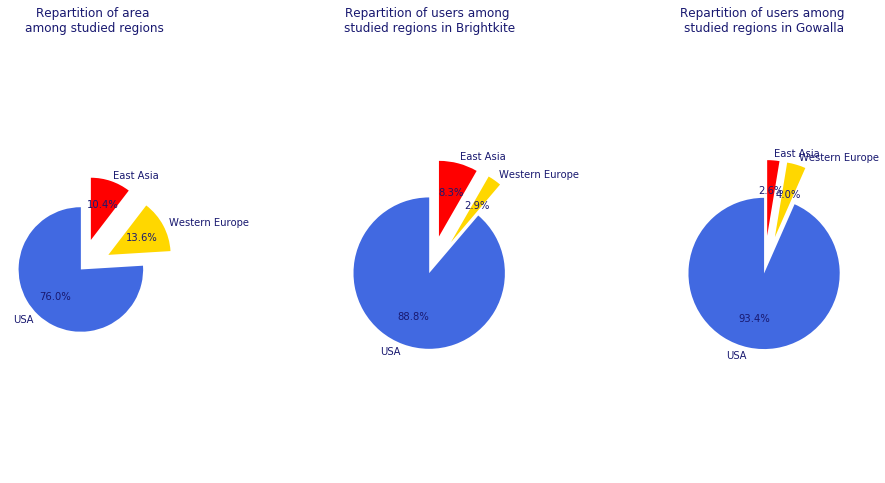

In [48]:
# Pie charts
fig, ax = plt.subplots(1,3, figsize = (15, 8))

#Repartition of area among studied regions
total_size = countries['land_area'].sum()
areas = [area*100/total_size for area in countries['land_area'].to_list()]
plot_pie_charts(areas, ax[0], "Repartition of area \namong studied regions")

#Repartition of users among studied regions in Brightkite
total_users_b = len(homes_in_b)
users_b_areas = [len(homes_b_usa), len(homes_b_europe), len(homes_b_asia)]
users_b_areas = [nb*100/total_users_b for nb in users_b_areas]
plot_pie_charts(users_b_areas, ax[1], "Repartition of users among \nstudied regions in Brightkite")

#Repartition of users among studied regions in Gowalla
total_users_g = len(homes_in_g)
users_g_areas = [len(homes_g_usa), len(homes_g_europe), len(homes_g_asia)]
users_g_areas = [nb*100/total_users_g for nb in users_g_areas]
plot_pie_charts(users_g_areas, ax[2], "Repartition of users among \nstudied regions in Gowalla")

plt.subplots_adjust(hspace = 1, wspace = 1)

plt.show()

## Distance from home

We are know interested to see how much people from the 3 portions of the world tend to travel far away from their homes.
We start by assigning to each user his home :

In [49]:
homes_in_b.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_europe' : 'home_in_europe','is_in_asia' : 'home_in_asia',
                            'is_in_usa' : 'home_in_usa', 'cell_coord' : 'cell_home'}, inplace = True)

homes_in_g.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_europe' : 'home_in_europe','is_in_asia' : 'home_in_asia',
                            'is_in_usa' : 'home_in_usa', 'cell_coord' : 'cell_home'}, inplace = True)


In [91]:
b_checkins = pd.merge(b_checkins, homes_in_b, how = 'left', on = 'user')
g_checkins = pd.merge(g_checkins, homes_in_g, how = 'left', on = 'user')

As we want to know how much people travel away from their homes thus we only keep the homes that have not been made in the same cell as the cell of the home :

In [92]:
#IF NEEDED
b_all_checkins = b_checkins.copy()
g_all_checkins = g_checkins.copy()

In [93]:
b_checkins = b_checkins[b_checkins['cell_home'] != b_checkins['cell_coord']]
g_checkins = g_checkins[g_checkins['cell_home'] != g_checkins['cell_coord']]

We are now setted to compute the distance between the home and the position of the checkin for each checkin :

In [66]:
b_checkins['dist_from_home'] = b_checkins.progress_apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)

g_checkins['dist_from_home'] = g_checkins.progress_apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)

100%|██████████| 2902101/2902101 [23:48<00:00, 2031.42it/s] 


In [94]:
# POUR ELOISE
b_checkins['dist_from_home'] = b_checkins.apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)

g_checkins['dist_from_home'] = g_checkins.apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)

In [95]:
b_checkins.to_csv(r'./data/b_with_dist.txt.gz', compression = 'gzip', index = False)
g_checkins.to_csv(r'./data/g_with_dist.txt.gz', compression = 'gzip', index = False)

In [21]:
b_checkins = pd.read_csv(data_folder + 'b_with_dist.txt.gz')
g_checkins = pd.read_csv(data_folder + 'g_with_dist.txt.gz')

We can now plot the 4 different plots :
- the overall distribution of mobility away from the users' homes
- the distribution of mobility away from the users' homes for the american users
- the distribution of mobility away from the users' homes for the western european users
- the distribution of mobility away from the users' homes for the east asian users

In [59]:
# Function that computes the distributions of the values in data and plots it using a scatter plot.
# The arguments are:
#    - data: the array containing the values for which we want to compute the distribution.
#    - ax: the axes of the plot on shich we will apply the scatter function.
#    - marker, color, m_size: type, edgecolor and size of the markers we want. m_size is set to 120 by default.
#    - bins_max, num_bins: max value for the logspace function, and number of values wanted for the bins. 
#                          Defalut values set respectively to 10^5 and 100 for this plot.
def plot_probability(data, ax, marker, color, label, m_size = 120, bins_max = pow(10,5), num_bins = 100):
    log_bins=np.logspace(0, np.log10(bins_max), num = num_bins)
    hist_values, bins = np.histogram(data, bins= log_bins, density=True)
    ax.scatter(bins[:-1], hist_values, marker= marker, s=m_size, facecolors='none', edgecolors=color, label=label)

In [96]:
b_checkins_usa = b_checkins[b_checkins['is_in_usa']]
b_checkins_europe = b_checkins[b_checkins['is_in_europe']]
b_checkins_asia = b_checkins[b_checkins['is_in_asia']]


g_checkins_usa = g_checkins[g_checkins['is_in_usa']]
g_checkins_europe = g_checkins[g_checkins['is_in_europe']]
g_checkins_asia = g_checkins[g_checkins['is_in_asia']]

In [97]:
def plot_distance_distribution(to_plot, name, ax):
    """ Plot the distance distribution of the checkins passed as arguments
    
    Parameters
    ----------
    to_plot : tuple
        Tuple of the form (b_df, g_df) where b_df is a dataframe related with the Brightkite dataset 
            and g_df a dataframe related with the Gowalla dataset
    name : str
        Title of the plot
    ax : axis
        Axis on which to plot
    """
    
    b_df = to_plot[0]
    g_df = to_plot[1]
    
    # BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(b_df['dist_from_home'], ax, 'o', 'b', 'Brightkite')

    # GOWALLA – computing and scatter plotting the distribution of home distances between friends.
    plot_probability(g_df['dist_from_home'], ax, '*', 'r', 'Gowalla')

    # Setting the axes' scales to be logarithmic.
    ax.set_xscale("log")
    ax.set_yscale("log")

    #Setting the limits of the axes to match the ones in the paper's plot.
    ax.set_xlim(10e-1, 10e4)
    ax.set_ylim(10e-8, 10e-1)

    # Naming the axes and resizing the labels
    ax.set_xlabel('Checkin distance from home (km)', size=20)
    ax.set_ylabel('Probability', size=20)

    # Adding the color legend and the title of the plot.
    ax.set_title(name, size=20)
    ax.legend()

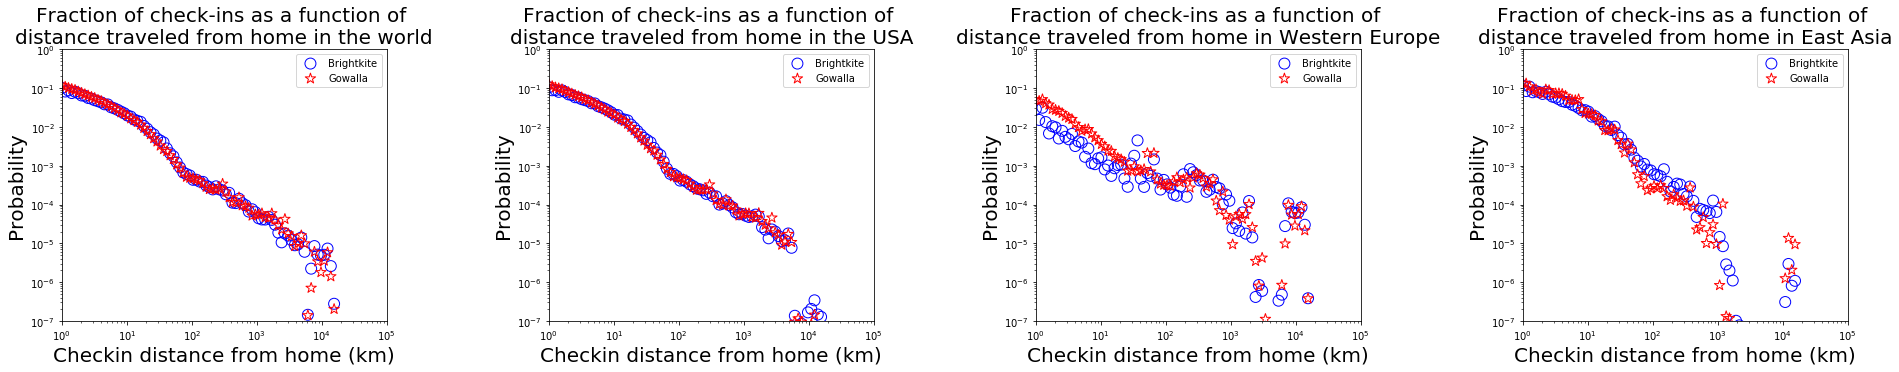

In [98]:
# Doing the final plot. Setting the figure size to (6,5) arbitrarily (slightly larger than tall).
fig, ax = plt.subplots(1, 4, figsize=(8*4, 5), sharey = False, sharex = False)

to_plot = [(b_checkins, g_checkins), (b_checkins_usa, g_checkins_usa), (b_checkins_europe, g_checkins_europe),
          (b_checkins_asia, g_checkins_asia)]
names = ['the world', 'the USA', 'Western Europe', 'East Asia']

for i in range(len(to_plot)) :
    plot_title = "Fraction of check-ins as a function of \ndistance traveled from home in "+names[i]
    plot_distance_distribution(to_plot[i], plot_title, ax[i])

plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

# Plot the distribution of how far people tend to travel from their home on the special dates and on each continent

In [29]:
events['beginning'] = events['beginning'].progress_apply(lambda x : pd.to_datetime(x, dayfirst = True))
events['end'] = events['end'].progress_apply(lambda x : pd.to_datetime(x, dayfirst = True))

100%|██████████| 6/6 [00:00<00:00, 499.08it/s]


In [71]:
#POUR ELOISE
events['beginning'] = events['beginning'].apply(lambda x : pd.to_datetime(x, dayfirst = True))
events['end'] = events['end'].apply(lambda x : pd.to_datetime(x, dayfirst = True))

The events we have selected are the followings :

In [72]:
events

,Unnamed: 0,Unnamed: 0.1,name,type,beginning,end,year
0,0,0,Christmas and New Year Eve,Religious and cultural event,2008-12-20,2009-01-02,2008
1,1,1,Christmas and New Year Eve,Religious and cultural event,2009-12-19,2010-01-02,2009
2,2,2,USA National Day,Cultural Event,2008-06-27,2008-07-07,2008
3,3,3,USA National Day,Cultural Event,2009-06-26,2009-07-06,2009
4,4,4,USA National Day,Cultural Event,2010-06-27,2010-07-07,2010
5,5,5,Winter Olympic Games,Major Sport Event,2010-02-12,2010-02-28,2010


For each special event and each continent, we find how far from their home people tend to travel.

In [140]:
def filter_event_days(checkins, name_col, event):
    """Returns the checkins that happenend during the event passed as parameter
    
    Parameters
    ----------
    checkins : DataFrame
        DataFrame on which we want to filter the ones that happenend during a certain period of time
    name_col : String
        Name of the column to test
    event : row of DataFrame
        Event defined by a period of time
    
    Return
    ------
    DataFrame :
        Contains only the checkins that happenend during the event
    """
    return checkins[(checkins[name_col] <= utc.localize(event['end'])) &
                                         (checkins[name_col] >= utc.localize(event['beginning']))].copy()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


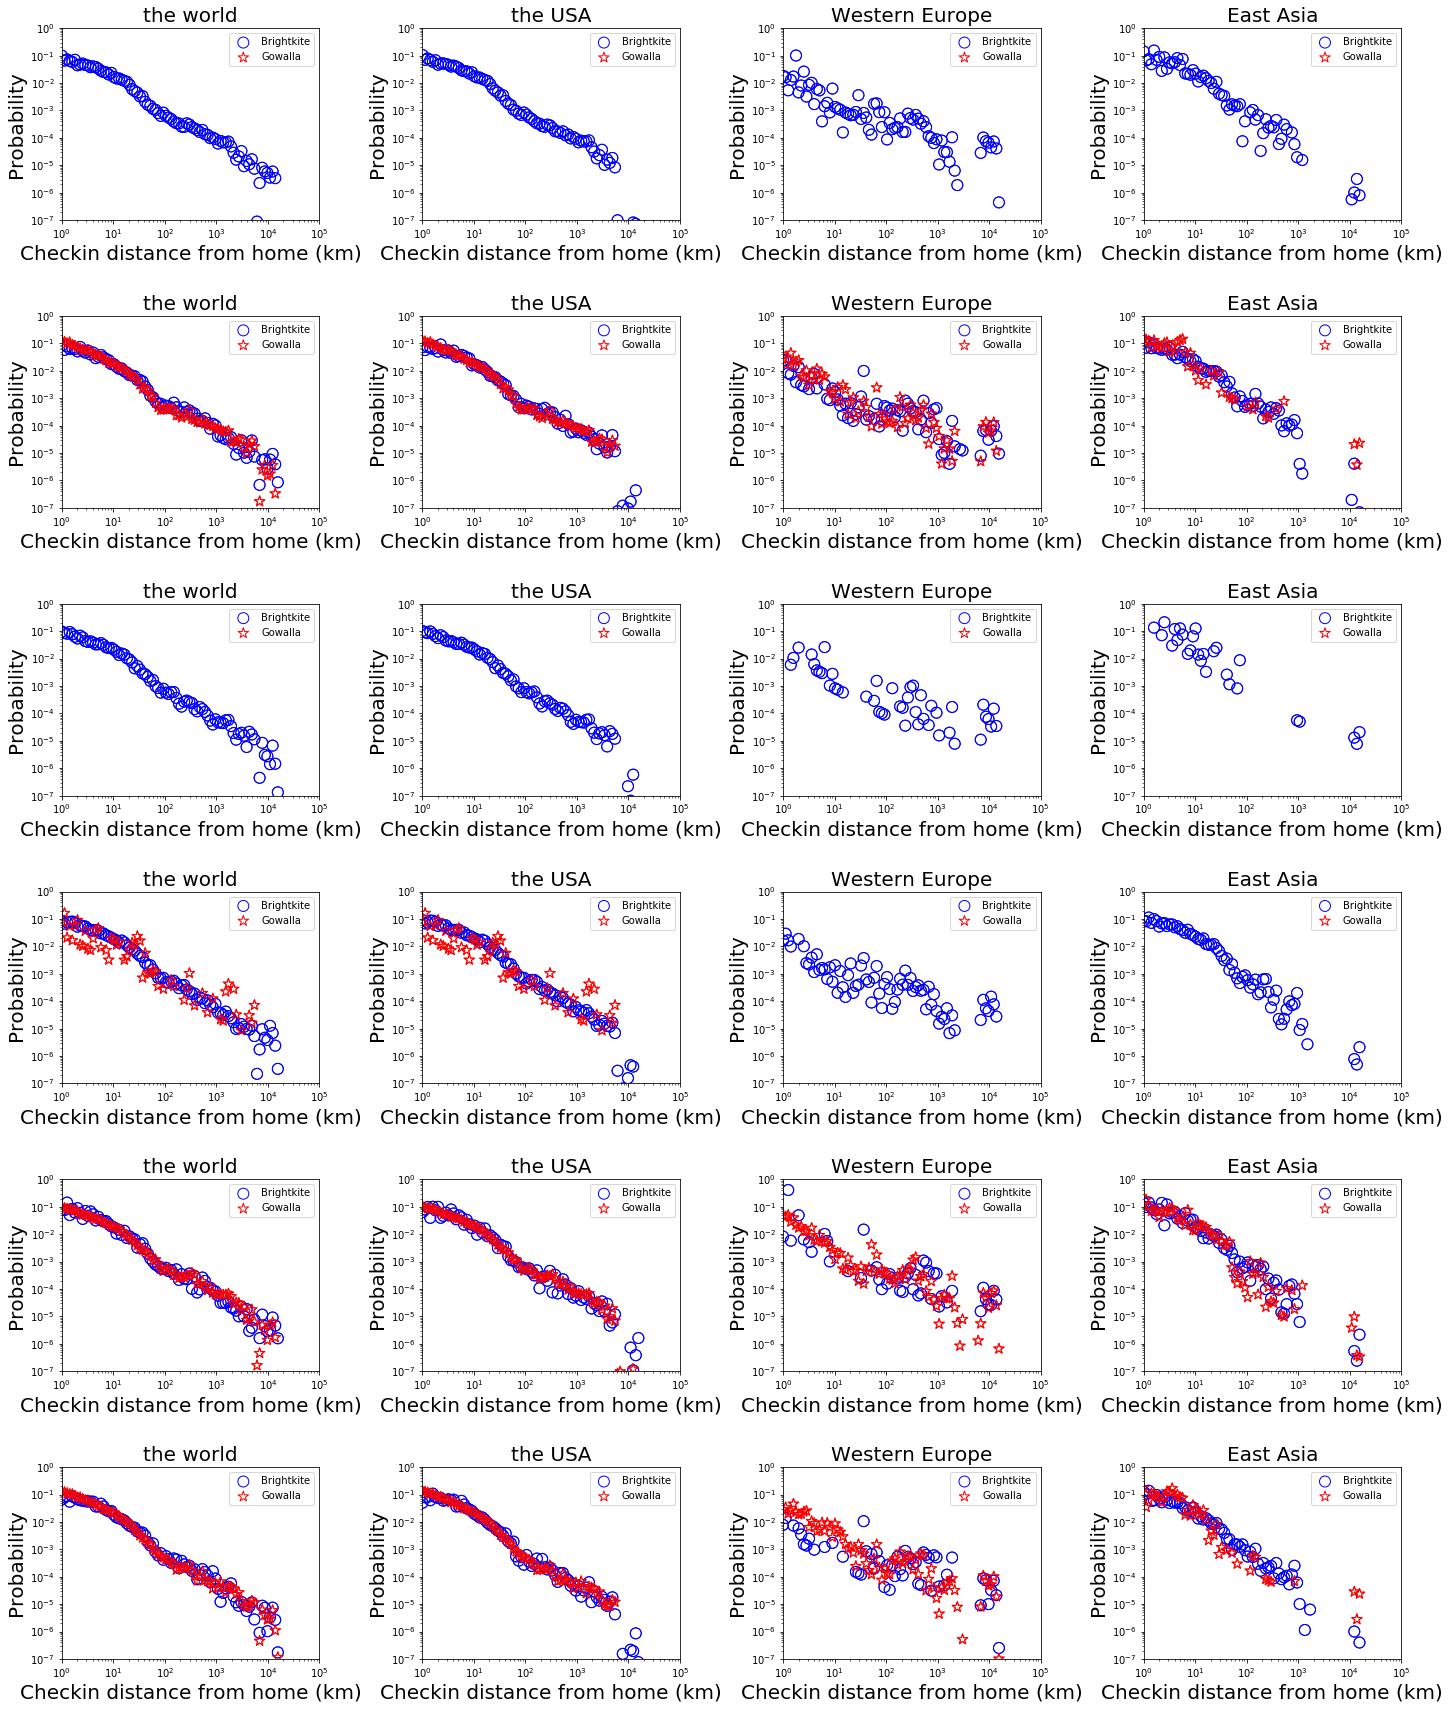

In [100]:
# Doing the final plot. Setting the figure size to (6,5) arbitrarily (slightly larger than tall).
fig, axs = plt.subplots(6,4, figsize=(6*4, 5*6))
    
utc=pytz.UTC

#end_titles = [' overall', ' in USA', ' in Western Europe', ' in East Asia']

for idx in events.index :
    #select only the ones in the correct timestamps 
    for i in range (len(to_plot)) :
        b_df = to_plot[i][0]
        g_df = to_plot[i][1]
        
        b_df ['checkin_time'] = b_df['checkin_time'].apply(lambda x : pd.to_datetime(x))
        g_df ['checkin_time'] = g_df['checkin_time'].apply(lambda x : pd.to_datetime(x))
        
        b_plot = filter_event_days(b_df,'checkin_time', events.iloc[idx])
        g_plot = filter_event_days(g_df,'checkin_time', events.iloc[idx])
        
        plot_title = str(events.loc[idx]['name']) + '\n '+ str(events.loc[idx]['year']) + ' in ' + str(names[i])
        plot_distance_distribution((b_plot, g_plot), plot_title, axs[idx,i])
        
        # BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
        plot_probability(b_plot['dist_from_home'], axs[idx,i], 'o', 'blue', 'Brightkite')

        # GOWALLA – computing and scatter plotting the distribution of home distances between friends.
        plot_probability(g_plot['dist_from_home'], axs[idx,i], '*', 'red', 'Gowalla')

plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

# Plot number of checkins per day overall and in each continent

We start by transforming each checkin_time into a datetime object.
At the same time, we add 2 new columns in the dataframe containing the day of the checkin and the other one the time, independtly of the day, of the checkin.

In [32]:
b_checkins['checkin_time'] = b_checkins['checkin_time'].progress_apply(lambda x : pd.to_datetime(x))
g_checkins['checkin_time'] = g_checkins['checkin_time'].progress_apply(lambda x : pd.to_datetime(x))

b_checkins['checkin_day'] = b_checkins['checkin_time'].progress_apply(lambda x : x.date())
g_checkins['checkin_day'] = g_checkins['checkin_time'].progress_apply(lambda x : x.date())

b_checkins['checkin_hour'] = b_checkins['checkin_time'].progress_apply(lambda x : x.time())
g_checkins['checkin_hour'] = g_checkins['checkin_time'].progress_apply(lambda x : x.time())

100%|██████████| 2902101/2902101 [00:26<00:00, 109461.38it/s]


In [101]:
#POUR ELOISE
b_checkins['checkin_time'] = b_checkins['checkin_time'].apply(lambda x : pd.to_datetime(x))
g_checkins['checkin_time'] = g_checkins['checkin_time'].apply(lambda x : pd.to_datetime(x))

b_checkins['checkin_day'] = b_checkins['checkin_time'].apply(lambda x : x.date())
g_checkins['checkin_day'] = g_checkins['checkin_time'].apply(lambda x : x.date())

b_checkins['checkin_hour'] = b_checkins['checkin_time'].apply(lambda x : x.time())
g_checkins['checkin_hour'] = g_checkins['checkin_time'].apply(lambda x : x.time())

In [102]:
b_checkins_usa = b_checkins[b_checkins['is_in_usa']]
b_checkins_europe = b_checkins[b_checkins['is_in_europe']]
b_checkins_asia = b_checkins[b_checkins['is_in_asia']]


g_checkins_usa = g_checkins[g_checkins['is_in_usa']]
g_checkins_europe = g_checkins[g_checkins['is_in_europe']]
g_checkins_asia = g_checkins[g_checkins['is_in_asia']]

To facilitate the continuation of the study we decided to put all the dataframe we are interested in in a dictionary where the key is the name of the dataframe and the value if the corresponding dataframe.

In [103]:
keys = ['b_checkins', 'g_checkins', 'b_checkins_usa', 'g_checkins_usa', 'b_checkins_europe', 'g_checkins_europe',
          'b_checkins_asia', 'g_checkins_asia']
values = [b_checkins, g_checkins, b_checkins_usa, g_checkins_usa, b_checkins_europe, g_checkins_europe,
          b_checkins_asia, g_checkins_asia]
dict_checkins = dict(zip(keys,values))

In [104]:
dict_checkins.keys()

dict_keys(['b_checkins', 'g_checkins', 'b_checkins_usa', 'g_checkins_usa', 'b_checkins_europe', 'g_checkins_europe', 'b_checkins_asia', 'g_checkins_asia'])

In [105]:
dict_checkins['b_checkins'].head()

,user,checkin_time,latitude,longitude,location_id,is_in_usa,is_in_europe,is_in_asia,cell_coord,Unnamed: 0,cell_home,count,lat_home,long_home,home_in_europe,home_in_usa,home_in_asia,dist_from_home,checkin_day,checkin_hour
0,0,2010-10-17 01:48:53+00:00,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,True,False,False,"(214, 175)",0.0,"(272, 176)",229.0,39.891261,-105.068678,False,True,False,17.266054,2010-10-17,01:48:53
1,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,True,False,False,"(272, 176)",0.0,"(272, 176)",229.0,39.891261,-105.068678,False,True,False,0.182758,2010-10-16,06:02:04
2,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,True,False,False,"(272, 176)",0.0,"(272, 176)",229.0,39.891261,-105.068678,False,True,False,0.023905,2010-10-16,03:48:54
3,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,True,False,False,"(216, 175)",0.0,"(272, 176)",229.0,39.891261,-105.068678,False,True,False,16.767932,2010-10-14,18:25:51
4,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,True,False,False,"(217, 175)",0.0,"(272, 176)",229.0,39.891261,-105.068678,False,True,False,16.620023,2010-10-14,00:21:47


Now for each of the dataframes contained in the `dict_checkins` we want to know by day the number of checkins that were realised.

In [106]:
def checkins_daily(checkins):
    """Add a column to the dataframe passed as parameter containing the number of checkins per day
    
    Parameter
    ---------
    checkins : DataFrame
        DataFrame in which we cant to count the number of checkins per day
        
    Return
    ------
    DataFrame :
        Contains 2 columns one with the day and the other one with the number of checkins in this day
    """
    checkins_daily = checkins.groupby('checkin_day').agg({'checkin_time':'count'}).reset_index()
    return checkins_daily.rename(columns = {'checkin_time' : 'checkin_count'})

In [107]:
dict_checkins_daily = dict()

for df_name in dict_checkins.keys():
    dict_checkins_daily[df_name + '_daily'] = checkins_daily(dict_checkins[df_name])

In [108]:
dict_checkins_daily.keys()

dict_keys(['b_checkins_daily', 'g_checkins_daily', 'b_checkins_usa_daily', 'g_checkins_usa_daily', 'b_checkins_europe_daily', 'g_checkins_europe_daily', 'b_checkins_asia_daily', 'g_checkins_asia_daily'])

In [109]:
dict_checkins_daily['b_checkins_daily'].head()

,checkin_day,checkin_count
0,2008-03-21,1
1,2008-03-22,12
2,2008-03-23,5
3,2008-03-24,8
4,2008-03-25,10


Finaly we can plot the function of the number of checkins per day for the different parts of the world we are studying. 

**Note** : The gathering of data for the 2 datasets did not start and end at the same time but both have the year 2009 in common. That is why we decided here to plot the number of count for each day of the year 2009 and for each parts of the world we are studying.

In [110]:
def annotate_point(text, point_a, point_s, xytext, label, ax) :
    """Annotate specific point
    
    Parameters
    ----------
    text : String
        Text to print on the annotation
    point_a : tuple
        Point to annotate on the plot
    point_s : tuple
        Point to scatter on the plot
    xytext : tuple 
        Position of the text on the plot
    label : string
        Label 
    ax : axis
        Axis on which to annotate the point
    """
    
    ax.annotate(text, point_a, xytext=xytext, color = 'forestgreen', size=15)
    ax.scatter(x=point_s[0], y=point_s[1], marker='D', label = label, s=130, color = 'forestgreen')

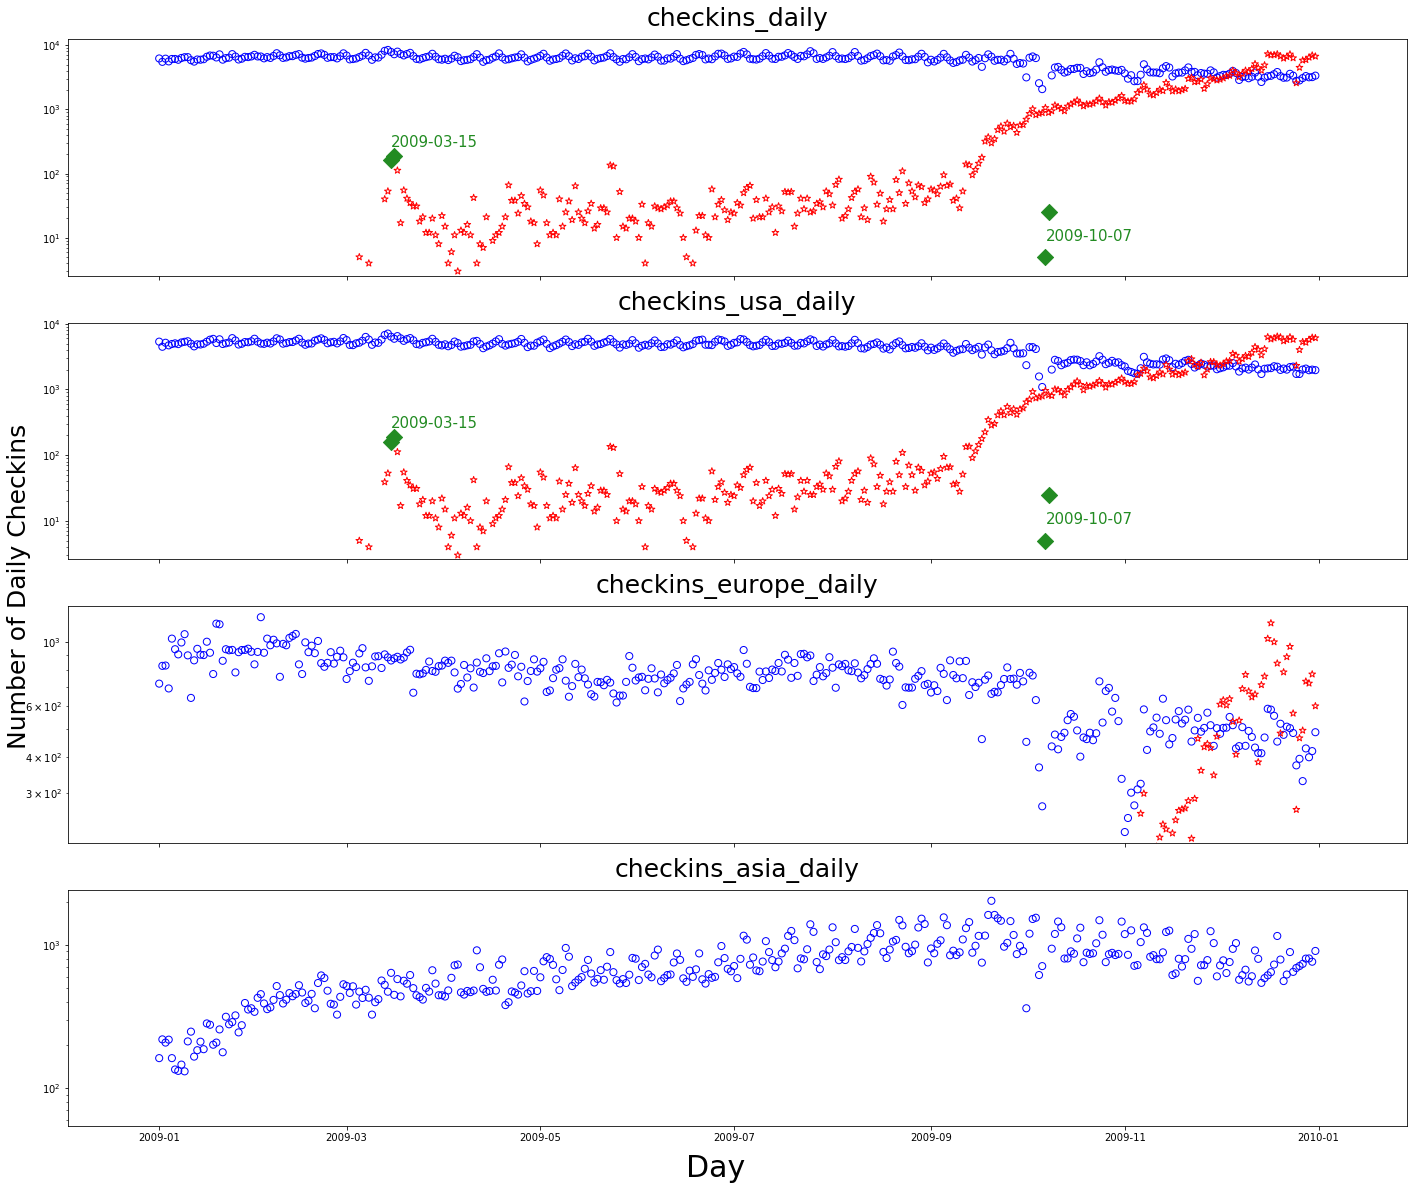

In [137]:
fig, axs = plt.subplots(4,1, figsize=(6*4, 20), sharex=True)

daily_keys = list(dict_checkins_daily.keys())
to_plot_daily = [(daily_keys[i], daily_keys[i+1]) for i in range(0,len(daily_keys), 2)]

for i in range(len(to_plot_daily)) :
    b_key = to_plot_daily[i][0]
    g_key = to_plot_daily[i][1]
    
    df_b = dict_checkins_daily[b_key]
    df_g = dict_checkins_daily[g_key]
    
    df_b_2009 = df_b[df_b['checkin_day'].apply(lambda date: date.year == 2009)]
    df_g_2009 = df_g[df_g['checkin_day'].apply(lambda date: date.year == 2009)]
    
    #BRIGHTKITE
    axs[i].scatter(x=df_b_2009['checkin_day'], y=df_b_2009['checkin_count'], marker='o', 
                               label = 'Brightkite', s=50, facecolors='none', edgecolors='blue')
    
    #GOWALLA
    axs[i].scatter(x=df_g_2009['checkin_day'], y=df_g_2009['checkin_count'], marker='*', 
                               label = 'Gowalla', s=50, facecolors='none', edgecolors='red')
    
    axs[i].set_title(b_key[2:], size=25, y=1.03)
    axs[i].set_yscale('log')
    
    if(i<2):
        #we notated in the case of the world and the USA some interested data point that we want to highlight
        
        #mystery day for BRIGHTKITE
        mystery_day = df_b_2009[df_b_2009['checkin_count'] < 150]
        annotate_point(mystery_day.iloc[0]['checkin_day'], (mystery_day.iloc[0]['checkin_day'], 100),
                       (mystery_day.iloc[0]['checkin_day'], mystery_day.iloc[0]['checkin_count']), 
                       (mystery_day.iloc[0]['checkin_day'], 9),'Brightkite', axs[i])
        axs[i].scatter(x=mystery_day.iloc[1]['checkin_day'], y=mystery_day.iloc[1]['checkin_count'], marker='D', 
                               label = 'Brightkite', s=130, color = 'forestgreen')
        
        #mystery days for GOWALLA
        mystery_days_2 = df_g_2009[(df_g_2009['checkin_count']>100) & (df_g_2009['checkin_day']<pd.to_datetime('2009-04'))]        
        annotate_point(mystery_days_2.iloc[0]['checkin_day'], (mystery_days_2.iloc[0]['checkin_day'], 100),
                       (mystery_days_2.iloc[0]['checkin_day'], mystery_days_2.iloc[0]['checkin_count']), 
                       (mystery_days_2.iloc[0]['checkin_day'], 260),'Gowalla', axs[i])
        axs[i].scatter(x=mystery_days_2.iloc[1]['checkin_day'], y=mystery_days_2.iloc[1]['checkin_count'], marker='D', 
                       label = 'Gowalla', s=130, color = 'forestgreen')
    
    
fig.text(0.5, 0.09, 'Day', ha='center', size=30)
fig.text(0.09, 0.5, 'Number of Daily Checkins', va='center', rotation='vertical', size=25)
plt.subplots_adjust(hspace = 0.2)

## TODO  plot average number of checkins per user in each continent

# Plot the number of checkins around the events in each parts of the world

For each part of the world and each event we are going to filter the checkins that happened in this part of the world and during this event : 

In [143]:
def add_items_to_dict(df, df_name, events = events):
    """ Return a dictionary containing a number of len(events) pairs (key, values) where :
        - the key correspond to a part of the world and the corresponding event
        - the value correspond to a DataFrame that contains for this part of the world, all the checkins that where made 
            in this part of the world and during the event
            
        Parameters
        ----------
        df : DataFrame
            DataFrame containing the all the checkins for a specific part of the world
        df_name : string
            Part of the name to give to the key of the dict_checkins dictionary
        events = events : DataFrame
            DataFrame containing all the events studied
        
        Return
        ------
        DataFrame :
            Dictionary containing for each part of the world passed as parameter (implicitly in the df parameter) 
            and for each event the checkins that happened during this event
    """
    dict_to_return = dict()
    for idx, event in events.iterrows():
        dict_to_return[str(df_name)+'_'+ str(event['name'])] = filter_event_days(df, 'checkin_day', event) 
    return dict_to_return

In [144]:
dict_checkins_daily_events = dict()

for df_name, df in dict_checkins_daily.items():
    #we use the keys and values of the dictionary containing for each part of the world the corresponding checkins
    #the keys and values of the dict_checkins_daily_events dictionnary will be updated in the add_items_to_dict function
    dict_checkins_daily_events.update(add_items_to_dict(df, df_name))

In [145]:
dict_checkins_daily_events.keys()

dict_keys(['b_checkins_daily_Christmas and New Year Eve', 'b_checkins_daily_USA National Day', 'b_checkins_daily_Winter Olympic Games', 'g_checkins_daily_Christmas and New Year Eve', 'g_checkins_daily_USA National Day', 'g_checkins_daily_Winter Olympic Games', 'b_checkins_usa_daily_Christmas and New Year Eve', 'b_checkins_usa_daily_USA National Day', 'b_checkins_usa_daily_Winter Olympic Games', 'g_checkins_usa_daily_Christmas and New Year Eve', 'g_checkins_usa_daily_USA National Day', 'g_checkins_usa_daily_Winter Olympic Games', 'b_checkins_europe_daily_Christmas and New Year Eve', 'b_checkins_europe_daily_USA National Day', 'b_checkins_europe_daily_Winter Olympic Games', 'g_checkins_europe_daily_Christmas and New Year Eve', 'g_checkins_europe_daily_USA National Day', 'g_checkins_europe_daily_Winter Olympic Games', 'b_checkins_asia_daily_Christmas and New Year Eve', 'b_checkins_asia_daily_USA National Day', 'b_checkins_asia_daily_Winter Olympic Games', 'g_checkins_asia_daily_Christmas 

In [146]:
dict_checkins_daily_events['b_checkins_daily_Christmas and New Year Eve'].head()

,checkin_day,checkin_count
638,2009-12-19,3825
639,2009-12-20,3296
640,2009-12-21,3115
641,2009-12-22,3136
642,2009-12-23,3588


In [ ]:
fig, axs = plt.subplots(3,4, figsize=(6*4, 3*5), sharey=True)

daily_events_keys = list(dict_checkins_daily_events.keys())
to_plot_daily_events = [(daily_events_keys[i], daily_events_keys[i+1]) for i in range(0,len(daily_events_keys), 2)]

for i in range(len(to_plot_daily_events)) :
    b_key = to_plot_daily_events[i][0]
    g_key = to_plot_daily_events[i][1]
    
    df_b = dict_checkins_daily_events[b_key]
    df_g = dict_checkins_daily_events[g_key]
    
    #BRIGHTKITE
    axs[i%3, i//3].scatter(x=df_b['checkin_day'], y=df_b['checkin_count'],marker='o', 
                               label = 'Brightkite', s=100, facecolors='none', edgecolors='blue')
    
    #GOWALLA
    axs[j%3, j//3].scatter(x=df_g['checkin_day'], y=df_g['checkin_count'],marker='*', 
                               label = 'Gowalla', s=100, facecolors='none', edgecolors='red')
    
    axs[i%3, i//3].set_yscale('log')
    axs[i%3, i//3].set_title(b_key[2:], size=15)
    plt.setp(axs[j%3, j//3].get_xticklabels(), Rotation=45)

fig.text(0.5, 0.04, 'Day', ha='center', size=25)
fig.text(0.04, 0.5, 'Number of Daily Checkins on Specific Events', va='center', rotation='vertical', size=25)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)



# we continue only studying the USA part of the world

<span style="background-color:yellow">TODO : Comment filter_dic</span>

In [46]:
def filter_dict(dict, callback_fucn):
    newDict = dict()
    # Iterate over all the items in dictionary
    for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
        if callback((key, value)):
            newDict[key] = value
    return newDict

dict_checkins_USA_daily_events = dict(filter(lambda elem: 'usa' in elem[0], dict_checkins_daily_events.items()))

dict_keys(['b_checkins_usa_daily_Christmas and New Year Eve', 'b_checkins_usa_daily_USA National Day', 'b_checkins_usa_daily_Winter Olympic Games', 'g_checkins_usa_daily_Christmas and New Year Eve', 'g_checkins_usa_daily_USA National Day', 'g_checkins_usa_daily_Winter Olympic Games'])

In [ ]:
dict_checkins_USA_daily_events.keys()

In [ ]:
dict_checkins_USA_daily_events['b_checkins_usa_daily_Christmas and New Year Eve']

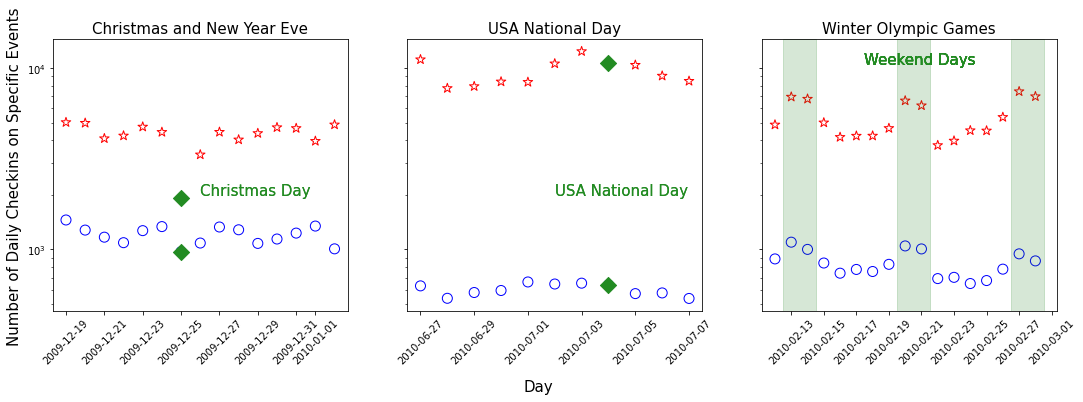

In [105]:
fig, axs = plt.subplots(1,3, figsize=(6*3, 5), sharey=True)

usa_daily_events_keys = list(dict_checkins_USA_daily_events.keys())
to_plot_usa_daily_events = [(usa_daily_events_keys[i], usa_daily_events_keys[i+1]) 
                            for i in range(0,len(usa_daily_events_keys), 2)]

for i in range(len(to_plot_usa_daily_events)) :
    
    b_key = to_plot_usa_daily_events[i][0]
    g_key = to_plot_usa_daily_events[i][1]
    
    df_b = dict_checkins_USA_daily_events[b_key]
    df_g = dict_checkins_USA_daily_events[g_key]
    
    #BRIGHTKITE
    axs[i%3, i//3].scatter(x=df_b['checkin_day'], y=df_b['checkin_count'],marker='o', 
                               label = 'Brightkite', s=100, facecolors='none', edgecolors='blue')
    #GOWALLA
    axs[j%3, j//3].scatter(x=df_g['checkin_day'], y=df_g['checkin_count'],marker='*', 
                               label = 'Gowalla', s=100, facecolors='none', edgecolors='red')
    
    axs[i].set_title(name[21:], size=15)
    plt.setp(axs[i].get_xticklabels(), Rotation=45)
    axs[i].set_yscale('log')
    
    #we notated some interested data points that we want to highlight

    if (i == 0) : #Christmas
        xmas_day= pd.to_datetime('2009-12-25')
        xmas_text= pd.to_datetime('2009-12-26')
        
        #BRIGHKITE
        xmas_count= df_b[df_b['checkin_day'] == xmas_day]['checkin_count']
        annotate_point('Christmas Day', (xmas_day, xmas_count), (xmas_day, xmas_count), 
                       (xmas_text, 2000), label = 'Brigthkite', axs[i])
        #GOWALLA
        xmas_count= df_g[df_g['checkin_day'] == xmas_day]['checkin_count']
        annotate_point('Christmas Day', (xmas_day, xmas_count), (xmas_day, xmas_count), (xmas_text, 2000),
                       label = 'Gowalla', axs[i])

    elif (i == 1) : #USA national day
        usa_day= pd.to_datetime('2010-07-04')
        usa_text= pd.to_datetime('2010-07-02')
        
        #BRIGHTKITE
        usa_count= df_b[df_b['checkin_day'] == usa_day]['checkin_count']
        annotate_point('USA National Day', (usa_day, usa_count),(usa_day, usa_count), xytext=(usa_text, 2000),
                       label = 'Brigthkite', axs[i])
        #GOWALLA
        usa_count= df_g[df_g['checkin_day'] == usa_day]['checkin_count']
        annotate_point('USA National Day', (usa_day, usa_count), (usa_day, usa_count),xytext=(usa_text, 2000),
                       label = 'Brigthkite', axs[i])
        
    elif(i==2) : #Weekends during the Olympic games
        #first WE
        we_day = pd.to_datetime('2010-02-12 12:00:00')
        we_day_2 = pd.to_datetime('2010-02-14 12:00:00')
        axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
        #seconde WE
        we_day = pd.to_datetime('2010-02-19 12:00:00')
        we_day_2 = pd.to_datetime('2010-02-21 12:00:00')
        axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
        #third WE
        we_day = pd.to_datetime('2010-02-26 12:00:00')
        we_day_2 = pd.to_datetime('2010-02-28 12:00:00')
        axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
        #text
        we_day = pd.to_datetime('2010-02-19 12:00:00')
        we_day_2 = pd.to_datetime('2010-02-21 12:00:00')
        we_text = pd.to_datetime('2010-02-17 12:00:00')
        axs[2].annotate('Weekend Days', (we_day, 10500),
                   xytext=(we_text, 10500), color = 'forestgreen', size=15)
    
fig.text(0.5, -0.1, 'Day', ha='center', size=15)
fig.text(0.09, 0.5, 'Number of Daily Checkins on Specific Events', va='center', rotation='vertical', size=15)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)

In [ ]:
def create_random_dates(start_date, end_date, nbOfDays):
    """Creates random span of dates of nbOfDays which needs to be in the period defined by the start and end date parameters
    
    Parameters 
    ----------
    start_date : datetime
        Beginning of the allowed period
    end_dtate : datetime
        End of the allowed period
    nbOfDays : int
        Number of days that the random span need to be
    
    Return
    ------
    tuple :
        Tuple of the random span of date
    """
    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days
    random_number_of_days = random.randrange(days_between_dates)
    random_date_start = start_date + datetime.timedelta(days=random_number_of_days)
    random_date_start = pd.to_datetime(random_date_start).date()
    random_date_end = pd.to_datetime(random_date_start + datetime.timedelta(days= nbOfDays))
    return (random_date_start, random_date_end)

In [307]:
start_date = np.max([g_checkins['checkin_time'].min(), b_checkins['checkin_time'].min()])
end_date = np.min([g_checkins['checkin_time'].max(), b_checkins['checkin_time'].max()])

xmas = events[events.name == 'Christmas and New Year Eve']
usa_day = events[(events.name == 'USA National Day')&(events.year == 2010)]
olympics = events[events.name == 'Winter Olympic Games']

nber_days_xmas = xmas.end.values-xmas.beginning.values
nber_days_usa_day = usa_day.end.values-usa_day.beginning.values
nber_days_olympics = olympics.end.values-olympics.beginning.values

xmas_rdm_dates = create_random_dates(start_date, end_date, nber_days_xmas)
usa_day_rdm_dates = create_random_dates(start_date, end_date, nber_days_usa_day)
olympics_rdm_dates = create_random_dates(start_date, end_date, nber_days_olympics)

In [372]:
events = events.append({'name' :'xmas_random', 'beginning': xmas_rdm_dates[0], 'end' : xmas_rdm_dates[1], 
               'year' : xmas_rdm_dates[0].year,'type' :'Random'},ignore_index = True)
events = events.append({'name' :'usa_day_random', 'beginning': usa_day_rdm_dates[0], 'end' : usa_day_rdm_dates[1], 
               'year' : usa_day_rdm_dates[0].year,'type' :'Random'},ignore_index = True)
events = events.append({'name' :'olympics_random', 'beginning': olympics_rdm_dates[0], 'end' : olympics_rdm_dates[1], 
               'year' : olympics_rdm_dates[0].year,'type' :'Random'},ignore_index = True)
events

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,name,type,beginning,end,year
0,0.0,0.0,0.0,Christmas and New Year Eve,Religious and cultural event,2008-12-20,2009-01-02,2008
1,1.0,1.0,1.0,Christmas and New Year Eve,Religious and cultural event,2009-12-19,2010-01-02,2009
2,2.0,2.0,2.0,USA National Day,Cultural Event,2008-06-27,2008-07-07,2008
3,3.0,3.0,3.0,USA National Day,Cultural Event,2009-06-26,2009-07-06,2009
4,4.0,4.0,4.0,USA National Day,Cultural Event,2010-06-27,2010-07-07,2010
5,5.0,5.0,5.0,Winter Olympic Games,Major Sport Event,2010-02-12,2010-02-28,2010
6,NaN,NaN,NaN,xmas_random,Random,2010-09-10,2010-09-24 00:00:00,2010
7,NaN,NaN,NaN,usa_day_random,Random,2010-04-08,2010-04-18 00:00:00,2010
8,NaN,NaN,NaN,olympics_random,Random,2009-10-01,2009-10-17 00:00:00,2009


### Conclusion 

We see that the proportion of checkins made in the USA is so big compared to the other countries, that it completely overtakes all variations of checkins in other places.
Hence, we will continue to analyse movements, but only in the USA.

## TODO nber of checkins arount each event in function of the nber of friends

In [128]:
nber_friends_b = b_edges.groupby('user').agg({'friend' : 'count'}).reset_index()
nber_friends_b.rename(columns = {'friend': 'friend_count'}, inplace = True)
nber_friends_g = g_edges.groupby('user').agg({'friend' : 'count'}).reset_index()
nber_friends_g.rename(columns = {'friend': 'friend_count'}, inplace = True)

In [129]:
b_checkins = pd.merge(b_checkins, nber_friends_b, on = 'user', how = 'left')
g_checkins = pd.merge(g_checkins, nber_friends_g, on = 'user', how = 'left')

In [157]:
dict_checkins_usa = dict()

dict_checkins_usa = add_items_to_dict(b_checkins_usa, 'b_checkins_usa', dict_checkins_usa)
dict_checkins_usa = add_items_to_dict(g_checkins_usa, 'g_checkins_usa', dict_checkins_usa)


In [374]:
dict_checkins_random = dict()

dict_checkins_random = add_items_to_dict(b_checkins_usa, 'b_checkins_usa', dict_checkins_random,
                                         events[events['type']=='Random'])
dict_checkins_random = add_items_to_dict(g_checkins_usa, 'g_checkins_usa', dict_checkins_random,
                                         events[events['type']=='Random'])
dict_checkins_random.keys()

dict_keys(['b_checkins_usa_xmas_random', 'b_checkins_usa_usa_day_random', 'b_checkins_usa_olympics_random', 'g_checkins_usa_xmas_random', 'g_checkins_usa_usa_day_random', 'g_checkins_usa_olympics_random'])

In [224]:
dict_checkins = add_items_to_dict(b_checkins, 'b_checkins', dict_checkins)
dict_checkins = add_items_to_dict(b_checkins, 'g_checkins', dict_checkins)

In [225]:
dict_checkins.keys()

dict_keys(['b_checkins', 'b_checkins_usa', 'b_checkins_europe', 'b_checkins_asia', 'g_checkins', 'g_checkins_usa', 'g_checkins_europe', 'g_checkins_asia', 'b_checkins__Christmas and New Year Eve', 'b_checkins__USA National Day', 'b_checkins__Winter Olympic Games', 'g_checkins__Christmas and New Year Eve', 'g_checkins__USA National Day', 'g_checkins__Winter Olympic Games', 'b_checkins_Christmas and New Year Eve', 'b_checkins_USA National Day', 'b_checkins_Winter Olympic Games', 'g_checkins_Christmas and New Year Eve', 'g_checkins_USA National Day', 'g_checkins_Winter Olympic Games'])

In [216]:
dict_checkins_events = dict()

dict_checkins_events['b_checkins_daily_Christmas and New Year Eve'] = dict_checkins_daily_events['b_checkins_daily_Christmas and New Year Eve']
dict_checkins_events['b_checkins_daily_USA National Day'] = dict_checkins_daily_events['b_checkins_daily_USA National Day']
dict_checkins_events['b_checkins_daily_Winter Olympic Games'] = dict_checkins_daily_events['b_checkins_daily_Winter Olympic Games']

dict_checkins_events['g_checkins_daily_Christmas and New Year Eve'] = dict_checkins_daily_events['g_checkins_daily_Christmas and New Year Eve']
dict_checkins_events['g_checkins_daily_USA National Day'] = dict_checkins_daily_events['g_checkins_daily_USA National Day']
dict_checkins_events['g_checkins_daily_Winter Olympic Games'] = dict_checkins_daily_events['g_checkins_daily_Winter Olympic Games']

In [183]:
dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve'] = pd.merge(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve'],
                                                                         nber_friends_b, on = 'user', how = 'left')

## Statistical tests

In [238]:
#P_value of different statistical tests

def p_value_hypothesis(name_1, name_2, p_value):
    if (p_value<0.05):
        print(p_value)
        print('We reject the hypothesis that the distribution of ' + name_1 + ' and ' + name_2 + ' are the same')
    else :
        print(p_value)
        print('We accept the hypothesis that the distribution of ' + name_1 + ' and ' + name_2 + ' are the same')

In [239]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins_usa['b_checkins_usa_USA National Day']['count']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['count']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_usa_Winter Olympic Games', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_USA National Day']['count']), 
                               np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['count']))
p_value_hypothesis('b_checkins_usa_USA National Day', 'b_checkins_usa_Winter Olympic Games', p_value)


1.5536933039464892e-107
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_usa_USA National Day are the same
1.0273267894913267e-16
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_usa_Winter Olympic Games are the same
3.1670300379341633e-55
We reject the hypothesis that the distribution of b_checkins_usa_USA National Day and b_checkins_usa_Winter Olympic Games are the same


In [240]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins_usa['g_checkins_usa_USA National Day']['count']))
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['count']))
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_usa_Winter Olympic Games', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_USA National Day']['count']), 
                               np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['count']))
p_value_hypothesis('g_checkins_usa_USA National Day', 'g_checkins_usa_Winter Olympic Games', p_value)


0.0
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_usa_USA National Day are the same
5.831085278245717e-127
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_usa_Winter Olympic Games are the same
5.655984945654147e-182
We reject the hypothesis that the distribution of g_checkins_usa_USA National Day and g_checkins_usa_Winter Olympic Games are the same


In [241]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['count']), 
                               np.array(dict_checkins['b_checkins_Christmas and New Year Eve']['checkin_count']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_Christmas and New Year Eve', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins['b_checkins_USA National Day']['checkin_count']), 
                               np.array(dict_checkins_usa['b_checkins_usa_USA National Day']['count']))
p_value_hypothesis('b_checkins_USA National Day', 'b_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['count']), 
                               np.array(dict_checkins['b_checkins_Winter Olympic Games']['checkin_count']))
p_value_hypothesis('b_checkins_usa_Winter Olympic Games', 'b_checkins_Winter Olympic Games', p_value)

1.4080813869807548e-17
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_Christmas and New Year Eve are the same
1.0030772531010265e-14
We reject the hypothesis that the distribution of b_checkins_USA National Day and b_checkins_usa_USA National Day are the same
5.156119368049745e-18
We reject the hypothesis that the distribution of b_checkins_usa_Winter Olympic Games and b_checkins_Winter Olympic Games are the same


In [243]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(dict_checkins['g_checkins_Christmas and New Year Eve']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_Christmas and New Year Eve', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins['g_checkins_USA National Day']['dist_from_home']), 
                               np.array(dict_checkins_usa['g_checkins_usa_USA National Day']['dist_from_home']))
p_value_hypothesis('g_checkins_USA National Day', 'g_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(dict_checkins['g_checkins_Winter Olympic Games']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_Winter Olympic Games', 'g_checkins_Winter Olympic Games', p_value)

3.866395421647998e-29
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_Christmas and New Year Eve are the same
1.4135702596106622e-15
We reject the hypothesis that the distribution of g_checkins_USA National Day and g_checkins_usa_USA National Day are the same
4.036665286651846e-26
We reject the hypothesis that the distribution of g_checkins_usa_Winter Olympic Games and g_checkins_Winter Olympic Games are the same


In [248]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(b_checkins_usa['dist_from_home']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_usa', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins['b_checkins_USA National Day']['dist_from_home']), 
                               np.array(b_checkins_usa['dist_from_home']))
p_value_hypothesis('b_checkins_USA National Day', 'b_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(b_checkins_usa['dist_from_home']))
p_value_hypothesis('b_checkins_usa_Winter Olympic Games', 'b_checkins_Winter Olympic Games', p_value)

4.387421369292471e-110
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_Christmas and New Year Eve are the same
0.022851261222837854
We reject the hypothesis that the distribution of b_checkins_USA National Day and b_checkins_usa_USA National Day are the same
2.419014217686683e-06
We reject the hypothesis that the distribution of b_checkins_usa_Winter Olympic Games and b_checkins_Winter Olympic Games are the same


In [247]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(g_checkins_usa['dist_from_home']), equal_var = False)
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_Christmas and New Year Eve', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins['g_checkins_USA National Day']['dist_from_home']), 
                               np.array(g_checkins_usa['dist_from_home']), equal_var = False)
p_value_hypothesis('g_checkins_USA National Day', 'g_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(g_checkins_usa['dist_from_home']), equal_var = False)
p_value_hypothesis('g_checkins_usa_Winter Olympic Games', 'g_checkins_Winter Olympic Games', p_value)

7.308089053037219e-121
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_Christmas and New Year Eve are the same
3.3736279286014072e-06
We reject the hypothesis that the distribution of g_checkins_USA National Day and g_checkins_usa_USA National Day are the same
5.688111031788713e-88
We reject the hypothesis that the distribution of g_checkins_usa_Winter Olympic Games and g_checkins_Winter Olympic Games are the same


In [284]:
dict_checkins_random.keys()

dict_keys(['b_checkins_usa_xmas_random', 'b_checkins_usa_usa_day_random', 'b_checkins_usa_olympics_random', 'g_checkins_usa_xmas_random', 'g_checkins_usa_usa_day_random', 'g_checkins_usa_olympics_random'])

In [385]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(dict_checkins_random['b_checkins_usa_xmas_random']['dist_from_home']))
p_value_hypothesis('b_checkins_usa_Christmas and New Year Eve', 'b_checkins_usa_xmas_random', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_USA National Day']['dist_from_home']), 
                               np.array(dict_checkins_random['b_checkins_usa_usa_day_random']['dist_from_home']))
p_value_hypothesis('b_checkins_usa_usa_day_random', 'b_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['b_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(dict_checkins_random['b_checkins_usa_olympics_random']['dist_from_home']))
p_value_hypothesis('b_checkins_usa_Winter Olympic Games', 'b_checkins_usa_olympics_random', p_value)

3.4634794377993845e-09
We reject the hypothesis that the distribution of b_checkins_usa_Christmas and New Year Eve and b_checkins_usa_xmas_random are the same
3.5486828104411703e-08
We reject the hypothesis that the distribution of b_checkins_usa_usa_day_random and b_checkins_usa_USA National Day are the same
0.005237268655486418
We reject the hypothesis that the distribution of b_checkins_usa_Winter Olympic Games and b_checkins_usa_olympics_random are the same


In [384]:
statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Christmas and New Year Eve']['dist_from_home']), 
                               np.array(dict_checkins_random['g_checkins_usa_xmas_random']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_Christmas and New Year Eve', 'g_checkins_usa_xmas_random', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_USA National Day']['dist_from_home']), 
                               np.array(dict_checkins_random['g_checkins_usa_usa_day_random']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_usa_day_random', 'g_checkins_usa_USA National Day', p_value)

statistic, p_value = ttest_ind(np.array(dict_checkins_usa['g_checkins_usa_Winter Olympic Games']['dist_from_home']), 
                               np.array(dict_checkins_random['g_checkins_usa_olympics_random']['dist_from_home']))
p_value_hypothesis('g_checkins_usa_Winter Olympic Games', 'g_checkins_usa_olympics_random', p_value)

1.9335567057686826e-138
We reject the hypothesis that the distribution of g_checkins_usa_Christmas and New Year Eve and g_checkins_usa_xmas_random are the same
1.1890713390255975e-70
We reject the hypothesis that the distribution of g_checkins_usa_usa_day_random and g_checkins_usa_USA National Day are the same
8.840861705097052e-10
We reject the hypothesis that the distribution of g_checkins_usa_Winter Olympic Games and g_checkins_usa_olympics_random are the same


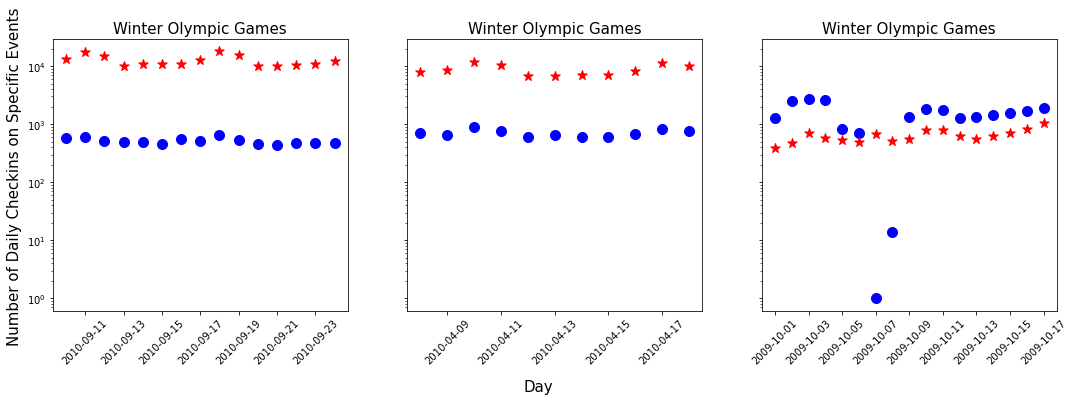

In [383]:
fig, axs = plt.subplots(1,3, figsize=(6*3, 5), sharey=True)

for i_rd, (name_rd, df_rd) in enumerate(dict_checkins_random.items()) :
    df_rd = df_rd.groupby(['checkin_day']).agg({'count':'count'}).reset_index()
    if(i_rd<3):
        axs[i_rd].scatter(x=df_rd['checkin_day'], y=df_rd['count'],marker='o', 
                             label = 'Brightkite', s=100, color = 'blue')
        axs[i_rd].set_title(name[21:], size=15)
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[i%3, i//4],bins = len(df), label = 'Brightkite', color='blue')
    else:
        j_rd = i_rd-3
        axs[j_rd].scatter(x=df_rd['checkin_day'], y=df_rd['count'],marker='*', 
                              label = 'Gowalla', s=100, color = 'red')
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[j%3, j//4],bins = len(df), label = 'Gowalla', color = 'red'
        plt.setp(axs[j_rd].get_xticklabels(), Rotation=45)
        axs[j_rd].set_yscale('log')

        
fig.text(0.5, -0.1, 'Day', ha='center', size=15)
fig.text(0.09, 0.5, 'Number of Daily Checkins on Specific Events', va='center', rotation='vertical', size=15)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)


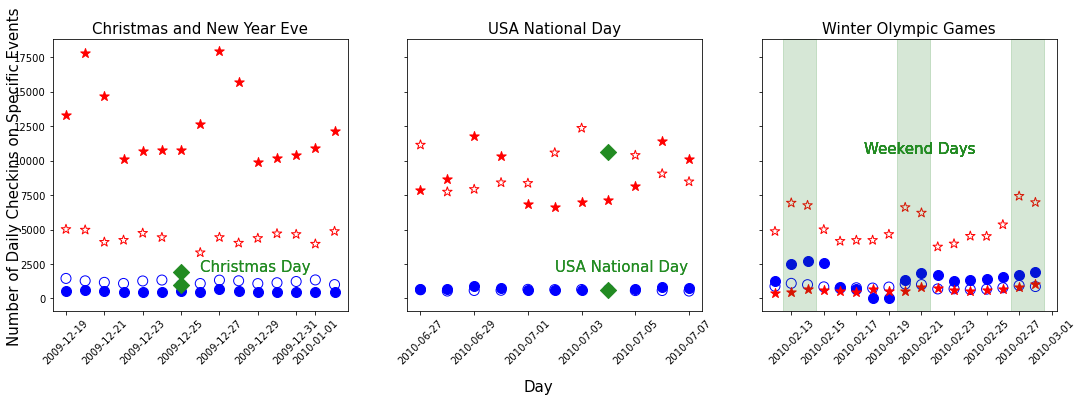

In [387]:
fig, axs = plt.subplots(1,3, figsize=(6*3, 5), sharey=True)

for ((i_rd, (name_rd, df_rd)), (i, (name, df))) in zip(enumerate(dict_checkins_random.items()),enumerate(dict_checkins_USA_daily_events.items())) :
    df_rd = df_rd.groupby(['checkin_day']).agg({'count':'count'}).reset_index()
    if(i_rd<3):
        axs[i_rd].scatter(x=df['checkin_day'], y=df_rd['count'],marker='o', 
                             label = 'Brightkite', s=100, color = 'blue')
        axs[i_rd].set_title(name[21:], size=15)
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[i%3, i//4],bins = len(df), label = 'Brightkite', color='blue')
    else:
        j_rd = i_rd-3
        axs[j_rd].scatter(x=df['checkin_day'], y=df_rd['count'],marker='*', 
                              label = 'Gowalla', s=100, color = 'red')
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[j%3, j//4],bins = len(df), label = 'Gowalla', color = 'red'
        plt.setp(axs[j_rd].get_xticklabels(), Rotation=45)
        #axs[j_rd].set_yscale('log')
    
    if(i<3):
        axs[i].scatter(x=df['checkin_day'], y=df['checkin_count'],marker='o', 
                               label = 'Brightkite', s=100, facecolors='none', edgecolors='blue')
        axs[i].set_title(name[21:], size=15)
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[i%3, i//4],bins = len(df), label = 'Brightkite', color='blue')
    else:
        j = i-3
        axs[j].scatter(x=df['checkin_day'], y=df['checkin_count'],marker='*', 
                               label = 'Gowalla', s=100, facecolors='none', edgecolors='red')
        #sns.histplot(x=df['checkin_day'], y=df['checkin_count'], ax = axs[j%3, j//4],bins = len(df), label = 'Gowalla', color = 'red'
        plt.setp(axs[j].get_xticklabels(), Rotation=45)
        #axs[j].set_yscale('log')
    if(i%3==0):
        xmas_day= pd.to_datetime('2009-12-25')
        xmas_text= pd.to_datetime('2009-12-26')
        xmas_count= df[df['checkin_day'] == xmas_day]['checkin_count']
        axs[0].annotate('Christmas Day', (xmas_day, xmas_count),
                   xytext=(xmas_text, 2000), color = 'forestgreen', size=15)
        axs[0].scatter(x=xmas_day, y=xmas_count, marker='D', s=130, color = 'forestgreen')
    if(i%3==1):
        usa_day= pd.to_datetime('2010-07-04')
        usa_text= pd.to_datetime('2010-07-02')
        usa_count= df[df['checkin_day'] == usa_day]['checkin_count']
        axs[1].annotate('USA National Day', (usa_day, usa_count),
                   xytext=(usa_text, 2000), color = 'forestgreen', size=15)
        axs[1].scatter(x=usa_day, y=usa_count, marker='D', s=130, color = 'forestgreen')
    
    we_day = pd.to_datetime('2010-02-12 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-14 12:00:00')
    axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
    we_day = pd.to_datetime('2010-02-19 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-21 12:00:00')
    axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
    we_day = pd.to_datetime('2010-02-26 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-28 12:00:00')
    axs[2].axvspan(we_day, we_day_2, alpha = 0.03, color = 'forestgreen')
    we_day = pd.to_datetime('2010-02-19 12:00:00')
    we_day_2 = pd.to_datetime('2010-02-21 12:00:00')
    we_text = pd.to_datetime('2010-02-17 12:00:00')
    #we_count = df[df['checkin_day']== we_text]['checkin_count']
    axs[2].annotate('Weekend Days', (we_day, 10500),
                   xytext=(we_text, 10500), color = 'forestgreen', size=15)
        


    
fig.text(0.5, -0.1, 'Day', ha='center', size=15)
fig.text(0.09, 0.5, 'Number of Daily Checkins on Specific Events', va='center', rotation='vertical', size=15)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)


## OPT filter by top_user